# Preprocess data

This notebook is an interactive script that extracts the data provided by the original authors into a consolidated and aligned data format for subsequent analyses.

This file extracts data from the following files:
- `moseq-drugs/original/syllablelabels.pkl`
- `moseq-drugs/original/fingerprints.pkl`
- `moseq-drugs/syllable_id_label_cluster.csv`

and generates the file
- `syllable_sequence_data.npz`

This file contains the following arrays for `n_sessions=501`, `session_length=36000`, and `n_syllables=90`:
- `session_syllables`, shape `(n_sessions, session_length)`, dtype `uint8`
    - Matrix of frame-rate syllable id sequences, [0,91). Each row is a session of data for a specific drug and dosage combination.
    - Syllable ids [0,90) are the same as those used in the original dataset, and they correspond to the 90 most frequently used syllables in the `original/syllablelabels.pkl` dataset.
    - Syllable id `90` (the 91st id) represents all syllables that were less frequently used, and which were discarded in subsequent analyses.
- `session_drug_name`, shape `(n_sessions,)`, dtype `U`
    - Name of drug administered at each session.
    - Drug names are given as 4 letter abbreviations, corresponding to:
        - ALPR: alprazolam
        - ATOM: atomoxetine
        - BUPR: bupropion
        - CHKO: chlorpromazine
        - CITA: citalopram
        - CLOZ: clozapine
        - CTRL: control
        - DIAZ: diazepam
        - FLUO: fluoxetine
        - HALO: haloperidol
        - METH: methamphetamine
        - MTPH: methylphenidate
        - MODA: modafinil
        - PHEN: phenelzine
        - RISP: risperidone
        - VENL: venlafaxine
- `session_drug_class`, shape `(n_sessions,)`, dtype `U`
    - Drug class of administered drug at each session
    - One of: benzo, antidepressant, antipsychotic, snri, ssri, stimulant, and control.
- `session_drug_dose_0to6`, shape `(n_sessions,)`, dtype `uint8`
    - Drug dose of administered drug at each session, on a scale of 0 to 6
    - The scale values correspond to:
        - 0: Extremely low
        - 1: Very low
        - 2: Low
        - 3: High
        - 4: Very high
        - 5: Extremely high
    - The map from absolute dosage [mg/kg] to discrete scale can be found in Supplementary Table 1 and in the `fingerprints.pkl` file.
- `perm_syllable_id`, shape `(n_syllables,)`, dtype `uint8`
    - Syllable id order to permute syllable ids by so that they grouped by pose dynamics trajectory similarity. Let `onehot_session_syllables` by the one-hot vectorized representation of `session_syllables`. Then,
    ```python
    # Permute one-hot syllable usages by feature similarity
    onehot_session_syllables_by_similarity = onehot_session_syllables[:, perm_syllable_id]

    # Permute syllables back to ordering by frequency
    onehot_session_syllables_by_freq = onehot_session_syllables_by_similarity[:, np.argsort(perm_syllable_id)]
    ```
    - `syllables_by_similarity = 
- `perm_syllable_cluster`, shape `(n_syllables,)`, dtype `U`
    - Cluster names associated with syllables, as ordered by `perm_syllable_id`
    - There are a total of 8 clusters. Note that these differ slightly from the 9 behavioral categories presented in the original paper. Please refer to the descriptions of `syllable_id_label_cluster*.npz`.
        - Still, Pause, Groom, Two-legged rear (Rear), Rear transition (Rear tx), Slow forward locomotion (Slow fwd), Fast forward locomotion (Fast fwd), and None


In [1]:
import pickle

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

In [2]:
DATASET_DIR = "/home/groups/swl1/eyz/data/moseq-drugs/"

### 1. Extract syllable labels

In [3]:
syllables_filepath = DATASET_DIR + "original/syllablelabels.pkl"

with open(syllables_filepath, 'rb') as f:
    syllables_all = pickle.load(f, encoding='latin1')

print (f"Loaded `syllables_all` from:\n\t{syllables_filepath}")
print(f"type={type(syllables_all)}, shape={syllables_all.shape}, dtype={syllables_all.dtype}")
print(f"min value={np.nanmin(syllables_all)}, max_value={np.nanmax(syllables_all)}, contains nans?={np.any(np.isnan(syllables_all))}")

n_syllables_all = int(np.nanmax(syllables_all)) + 1  # 0-indexed

Loaded `syllables_all` from:
	/home/groups/swl1/eyz/data/moseq-drugs/original/syllablelabels.pkl
type=<class 'numpy.ndarray'>, shape=(18036000,), dtype=float64
min value=0.0, max_value=158.0, contains nans?=True


In [4]:
# Reorganize vector in matrix, shape (n_sessions, session_length)
n_sessions = 501
session_length = 36000  # 20 minutes @ 30 fps
syllables_all = syllables_all.reshape(n_sessions, session_length)

In [5]:
session_nan_idxs, frame_nan_idxs = np.nonzero(np.isnan(syllables_all))

unique_session_nan_idxs = np.unique(session_nan_idxs)
unique_frame_nan_idxs = np.unique(frame_nan_idxs)

print(f"# sessions with NaNs: {len(unique_session_nan_idxs)}")
print(f"Unique frames with NaNs: {unique_frame_nan_idxs}")

# sessions with NaNs: 501
Unique frames with NaNs: [0 1 2]


In [6]:
# Backfill the first 3 frames with the 4th frame's syllable assignment
syllables_all[:,:3] = syllables_all[:,[3]]
# syllables_all = syllables_all[:,3:]

# Syllable labels should now be free of NaNs
assert np.all(np.isfinite(syllables_all))

# Convert array to integer dtype
syllables_all = np.asarray(syllables_all, dtype=int)

#### Truncate syllable vocabulary size

The AR-HMM yielded a total of 159 syllables when fit to the whole dataset.
This vocabulary is truncated to retain only the most frequently used syllables,

In [7]:
# Count the number of types that a syllable is used, across the whole dataset
# Ignore the backfilled syllables in this count, as Wiltschko et al. did
unique_syllables, global_usage_count = np.unique(syllables_all[:,3:], return_counts=True)  # (shape, n_syllables)
global_usage_freq = global_usage_count / syllables_all.size
print(
    f"Highest usage count (syllable {global_usage_count.argmax()}): "
    f"{global_usage_count.max()} ({int(global_usage_freq.max()*100)}%)"
)
print(
    f"Lowest usage count (syllable {global_usage_count.argmin()}): "
    f"{global_usage_count.min()} ({int(global_usage_freq.min()*100)}%)")
print()

# Syllables are conveniently already sorted from highest to lowest usage
print(
    f"Syllables sorted from highest to lowest frequency? "
    f"{np.all((global_usage_freq[:-1] - global_usage_freq[1:]) >= 0)}"
)

Highest usage count (syllable 0): 498386 (2%)
Lowest usage count (syllable 158): 1 (0%)

Syllables sorted from highest to lowest frequency? True


In [8]:
# Minimal number of syllables needed to express 90% of frames
target_cumulative_freq = 0.90
global_cumulative_freq = np.cumsum(global_usage_freq)
n_syllables_target = np.argmin(np.abs(global_cumulative_freq - target_cumulative_freq))

print(f"{int(target_cumulative_freq*100)}% of total frames captured by {n_syllables_target} most frequent syllables.")

# Wiltschko et al. chose to truncate number of syllables retained to 90 for convenience
n_syllables_final = 90
final_cumulative_freq = global_usage_freq[:n_syllables_final].sum()
print(f"Reduced to {n_syllables_final} syllables for convenience; captures {int(final_cumulative_freq*100)}% of total frames.")


90% of total frames captured by 92 most frequent syllables.
Reduced to 90 syllables for convenience; captures 88% of total frames.


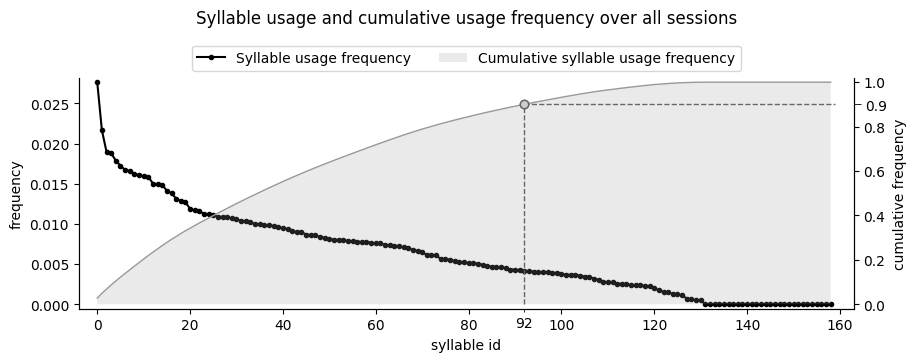

In [9]:
plt.figure(figsize=(10,3))

# --------------------------------------
# Global usage frequency vs. syllable id
ax = plt.gca()
line_freq, = ax.plot(global_usage_freq, c='k', marker='.')
ax.set_xlabel('syllable id')
ax.set_ylabel("frequency")

# --------------------------------------------------------------------
# Global cumulative usage frequency vs. syllable id, right-hand y-axis
axc = ax.twinx()  # share x-axis
line_cumulative, = axc.plot(global_cumulative_freq, lw=1, c='0.6')
poly_cumulative = axc.fill_between(
    np.arange(n_syllables_all), 0, global_cumulative_freq, facecolor='0.6', alpha=0.2
)
axc.set_ylabel("cumulative frequency")

# -------------------------------------
# Add crosshair on 90% frames explained
axc.plot(
    [n_syllables_target, n_syllables_target], [0, target_cumulative_freq],
    c='0.4', ls='--', lw=1, label="90% frames explained"
)
axc.plot(
    [n_syllables_target, n_syllables_all], [target_cumulative_freq, target_cumulative_freq],
    c='0.4', ls='--', lw=1,
)

# Add marker
axc.plot(
    [n_syllables_target, n_syllables_target], [target_cumulative_freq, target_cumulative_freq],
    c='0.8', marker='o', ms=6, mec='0.4'
)

# Add ticks on x-axis and right y-axis
axc.set_xticks([n_syllables_target], minor=True)
axc.set_yticks([target_cumulative_freq], minor=True)
axc.xaxis.set_minor_formatter(mpl.ticker.FormatStrFormatter("%d"))
axc.yaxis.set_minor_formatter(mpl.ticker.FormatStrFormatter("%.1f"))
axc.tick_params(axis='both', which='minor', length=5)

# ---------------------
# Tighten margins
ax.margins(x=0.025, y=0.02)
axc.margins(y=0.02)

# ---------------------
# Add legend above plot
ax.legend(
    handles=[line_freq, poly_cumulative],
    labels=["Syllable usage frequency", "Cumulative syllable usage frequency"],
    bbox_to_anchor=[0.5, 1], loc='lower center',
    ncol=2,
)

# ---------------------
# Add title
plt.title("Syllable usage and cumulative usage frequency over all sessions", y=1.2)

sns.despine(top=True, right=False)

**Figure A1.**
Syllable usage (black line, left y-axis) and cumulative usage frequency (shaded gray region, right y-axis).
Syllables are order from most frequently used (_2.7%_, or _498392/18036000_ frames) to least frequently used (_0.0%_, or _1/18036000_ frames).
The 90 most frequently used syllables are retained for subsequent analysis; discarded syllables are indicated with the token `-1`.

This figure reproduces Extended Data Fig. 2c from Wiltschko et al. (2020.)

In [10]:
syllables_90 = np.where(syllables_all < 90, syllables_all, 90)

print(f"type={type(syllables_90)}, shape={syllables_90.shape}, dtype={syllables_90.dtype}")
print(f"min value={np.nanmin(syllables_90)}, max_value={np.nanmax(syllables_90)}, contains nans?={np.any(np.isnan(syllables_90))}")

type=<class 'numpy.ndarray'>, shape=(501, 36000), dtype=int64
min value=0, max_value=90, contains nans?=False


**We reassign all excluded syllables to the id `90`.**

### 2. Extract drug and dosage experimental information

In [11]:
fingerprints_filepath = DATASET_DIR + "original/fingerprints.pkl"
with open(fingerprints_filepath, 'rb') as f:
    fingerprints, fingerprint_labels = pickle.load(f, encoding='latin1')

In [12]:
# Extract the drug name, class, and dosage associated with each session
drug_names_long = fingerprint_labels['drug']
drug_classes = fingerprint_labels['drug_class']
drug_doses_mg_per_kg = fingerprint_labels['dose']  # units: mg/kg

print(f'{len(drug_names_long)=}, {len(drug_classes)=}, {len(drug_doses_mg_per_kg)=}')
print()
print(f"Drug names ({len(set(drug_names_long))}, including control): {set(drug_names_long)}")
print(f"Drug classes ({len(set(drug_classes))}): {set(drug_classes)}")

len(drug_names_long)=501, len(drug_classes)=501, len(drug_doses_mg_per_kg)=501

Drug names (16, including control): {'phenelzine', 'modafinil', 'alprazolam', 'venlafaxine', 'risperidone', 'control', 'atomoxetine', 'clozapine', 'diazepam', 'haloperidol', 'bupropion', 'citalopram', 'fluoxetine', 'methylphenidate', 'chlorpromazine', 'methamphetamine'}
Drug classes (7): {'stimulant', 'control', 'benzo', 'antipsychotic', 'antidepressant', 'ssri', 'snri'}


**Convert drug names to abbreviations**

In [13]:
drug_name_abbrv_map = {
    'alprazolam': 'ALPR',
    'atomoxetine': 'ATOM',
    'bupropion': 'BUPR',
    'chlorpromazine': 'CHKO',
    'citalopram': 'CITA',
    'clozapine': 'CLOZ',
    'control': 'CTRL',
    'diazepam': 'DIAZ',
    'fluoxetine': 'FLUO',
    'haloperidol': 'HALO',
    'methamphetamine': 'METH',
    'methylphenidate': 'MTPH',
    'modafinil': 'MODA',
    'phenelzine': 'PHEN',
    'risperidone': 'RISP',
    'venlafaxine': 'VENL',
}

drug_names = [drug_name_abbrv_map[name] for name in drug_names_long]

**Convert drug dosages to 0-6 (extremely low to extremely high) scale**

In [14]:
# Convert dosage [mg/kg] to a discrete scale of [0: 'Extremely Low', 1: 'Very Low', 2: 'Low', 3: 'Medium', 4: 'High', 5: 'Very High']
# This is the same scale used in the original paper.
# Note that saline controls are mapped to a value of 2 or "Low"

# Dictionary mapping mg/kg dosages to qualitative scale
highlow_dose_map = fingerprint_labels['highlow_dose_mapping']

print("mg/kg dosage to high-low map:")
for name in sorted(set(drug_names_long)):
    print(f'\t{name}:\t{highlow_dose_map[name]}')

# Dictionary mapping qualitative scale to integer scale, 0-5
highlow_scale_map = dict(zip(['Extremely Low','Very Low', 'Low', 'Medium', 'High', 'Very High'], range(6)))

drug_doses_scale = np.array([
    highlow_scale_map[highlow_dose_map[name][dose]]
    for name, dose in zip (drug_names_long, drug_doses_mg_per_kg)
])

mg/kg dosage to high-low map:
	alprazolam:	{0.25: 'Medium', 0.5: 'High', 2.0: 'Very High', 0.1: 'Low'}
	atomoxetine:	{0.25: 'Low', 2.0: 'High'}
	bupropion:	{40.0: 'Very High', 10.0: 'Medium', 20.0: 'High', 5.0: 'Low'}
	chlorpromazine:	{0.25: 'Low', 1.0: 'High'}
	citalopram:	{0.25: 'Low', 10.0: 'High'}
	clozapine:	{0.25: 'Low', 10.0: 'High'}
	control:	{0: 'Low'}
	diazepam:	{0.5: 'Low', 2.0: 'High'}
	fluoxetine:	{10.0: 'Medium', 5.0: 'Low', 30.0: 'Very High', 15.0: 'High'}
	haloperidol:	{0.25: 'Very Low', 0.5: 'Low', 3.0: 'High', 0.1: 'Extremely Low', 6.0: 'Very High', 1.0: 'Medium'}
	methamphetamine:	{0.5: 'Low', 2.0: 'High'}
	methylphenidate:	{2.5: 'Low', 10.0: 'High', 20.0: 'Very High', 5.0: 'Medium'}
	modafinil:	{32.0: 'Low', 128.0: 'High'}
	phenelzine:	{2.5: 'Low', 12.5: 'High'}
	risperidone:	{0.25: 'Medium', 0.5: 'High', 0.1: 'Low', 1.0: 'Very High'}
	venlafaxine:	{2.5: 'Low', 10.0: 'High'}


**Aggregate syllable usage frequency vs. drug, dosage, and class**

In [15]:
# Summarize behavior in a session as the frequency of expression
# NaN syllables now located in the last column, session_counts[:,-1]
session_counts = np.zeros((n_sessions, 91), dtype=int)

for i in range(n_sessions):
    tmp_ids, tmp_counts = np.unique(syllables_90[i], return_counts=True)
    session_counts[i][tmp_ids] = tmp_counts

# Convert counts to frequency
session_freqs = session_counts / session_counts.sum(axis=-1, keepdims=True)

# Remove discarded syllables. NB: Columns do not sum to 1; gap is the nan syllable frequency
session_freqs = session_freqs[:,:-1]

# Check that our computed values are the same as "MoSeq fingerprint" summary provided by the authors
wiltschko_freqs = fingerprints['moseq']
assert np.allclose(session_freqs, wiltschko_freqs, atol=1e-4, rtol=0)

In [16]:
# Make name-and-dose labels and ticks
name_and_dose = [f"{drug}-{dose}" for drug, dose in zip(drug_names, drug_doses_scale)]
_, idx_name_and_dose, name_and_dose_counts = np.unique(name_and_dose, return_index=True, return_counts=True)

# Ensure that name x dose names and counts are in the original order
unique_name_and_dose = [name_and_dose[i] for i in sorted(idx_name_and_dose)]
name_and_dose_counts = np.array([name_and_dose_counts[i] for i in np.argsort(idx_name_and_dose)])

name_and_dose_edges = np.cumsum(name_and_dose_counts)
name_and_dose_ticks = np.cumsum(name_and_dose_counts) - name_and_dose_counts / 2

# ---------------------------------------------------------------------------
# Make drug class labels and ticks
_, idx_classes, class_counts = np.unique(drug_classes, return_index=True, return_counts=True)

# Ensure that class labels and counts are in the original order
unique_classes = [drug_classes[i] for i in sorted(idx_classes)]
class_counts = np.array([class_counts[i] for i in np.argsort(idx_classes)])

class_edges = np.cumsum(class_counts)
class_ticks = np.cumsum(class_counts) - class_counts/2

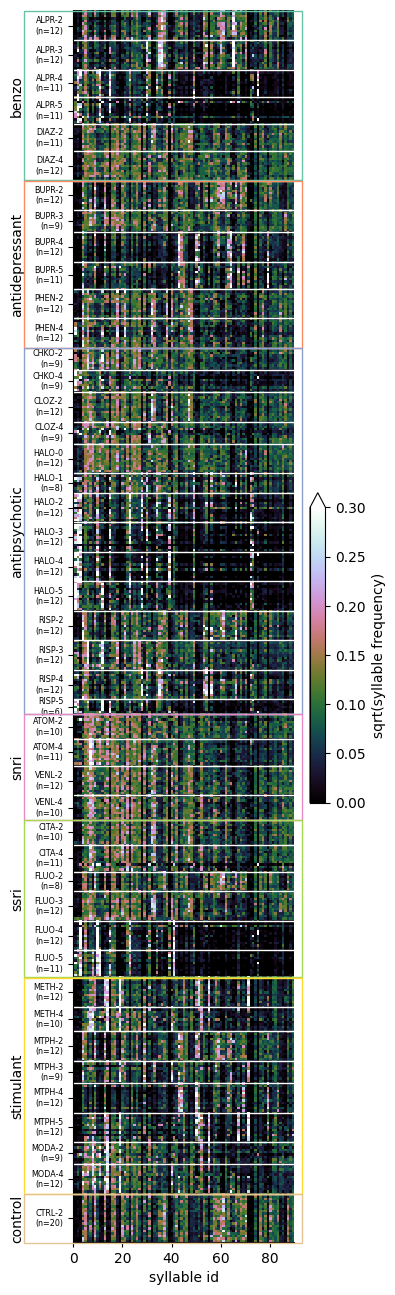

In [17]:
plt.figure(figsize=(4,16))
ax = plt.gca()

# Normalization scheme used in Wiltschko et al. notebook and figure
# This is a bit of weird color normalization...
im = ax.imshow(
    np.sqrt(session_freqs),
    cmap='cubehelix', clim=(0,0.3), interpolation='none'
)

# -------------------------------------------------------------
# Set innermost level left labels: name x dose
ax.hlines(name_and_dose_edges[:-1], 0, 90, color='white', lw=1)
ax.set_yticks(
    name_and_dose_ticks,
    [f"{name}\n(n={num})" for name, num in zip(unique_name_and_dose, name_and_dose_counts)],
    va='center',
    fontsize='xx-small'
)

# -------------------------------------------------------------
# Draw outermost rectangle: drug class
x0 = -20
width = (np.abs(x0) + 90) + 3
for i_class, color in enumerate(mpl.colormaps['Set2'].colors[:len(unique_classes)]):
    y0 = class_edges[i_class-1] if i_class > 0 else 0
    y1 = class_edges[i_class]
    
    rect = Rectangle((x0, y0+0.1), width, y1-y0-0.2, ec=color, fc='none', clip_on=False, zorder=5)
    ax.add_patch(rect)

    ax.text(-20, y0 + (y1-y0)/2, unique_classes[i_class],
        va='center', ha='right', rotation=90,
        clip_on=False
    )

# -------------------------------------------------------------
# Format x-axis
ax.set_xlabel("syllable id")

ax.set_xlim(0, 90)

plt.colorbar(im, fraction=0.05, extend='max', label='sqrt(syllable frequency)')

sns.despine()

**Figure.**
Square root of syllable usage frequency per session.
Every session of data is represented as a single row in the heatmap
Sessions are organized by drug and dosage scale; the y-axis label indicates the drug, dosage scale, and the number of sessions/subjects.
Different drug-dosage combinations are seperated by white horizontal lines for visualization.
Drug classes are indicated by rectangular boxes.

This reproduces Figure 2D of Wiltschko et al. (2020).

**Visualization with sorted syllables**

We wondered if some structure might appear when the syllable ids are clusted by pose dynamics similarity. The syllable ids are invariant to permutation and so this operation would not fundamentally change any of the data or conclusions; however, it assists with visual identification of possible latent structure the data.

In [18]:
syllable_name_filepath = DATASET_DIR + "syllable_id_label_cluster.csv"
syllable_id_perm = np.loadtxt(syllable_name_filepath, dtype=None, delimiter=',', skiprows=1, usecols=0)
syllable_id_perm = np.asarray(syllable_id_perm, dtype=int)

print(f"Total usage frequency of named ids: {int(global_usage_freq[syllable_id_perm].sum()*100)}%")

Total usage frequency of named ids: 88%


In [19]:
perm_cluster_names = np.loadtxt(syllable_name_filepath, dtype='U', delimiter=',', skiprows=1, usecols=2)

# Make x-axis syllable cluster labels and ticks
unique_cluster_names, idxs, cluster_counts \
    = np.unique(perm_cluster_names, return_index=True, return_counts=True)

# Sort cluster names and counts in the order that they were seen
sorted_idxs = np.argsort(idxs)
unique_cluster_names = [str(unique_cluster_names[i]) for i in sorted_idxs]
cluster_counts = np.array([cluster_counts[i] for i in sorted_idxs])

# Set bounding edges and label tick location
cluster_edges = np.cumsum(cluster_counts)
cluster_ticks = np.cumsum(cluster_counts) - cluster_counts/2

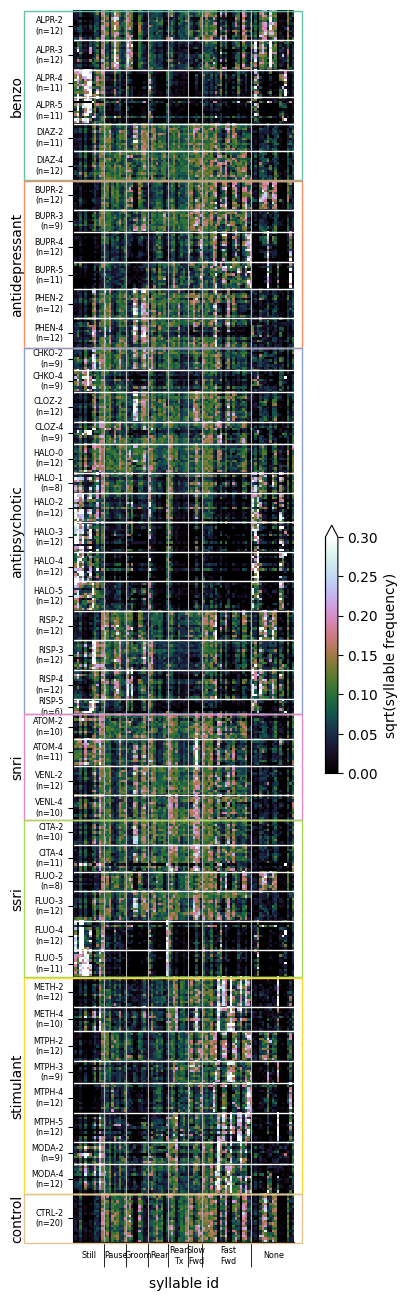

In [20]:
# Make same plot as above, but with syllables permuted by cluster grouping.

plt.figure(figsize=(8,16))
ax = plt.gca()

# Normalization scheme used in Wiltschko et al. notebook and figure
# This is a bit of weird color normalization...
im = ax.imshow(
    np.sqrt(session_freqs[:,syllable_id_perm]),
    cmap='cubehelix', clim=(0,0.3), interpolation='none'
)

plt.colorbar(im, fraction=0.02, extend='max', label='sqrt(syllable frequency)')

# -------------------------------------------------------------
# Set innermost level left labels: name x dose
ax.hlines(name_and_dose_edges[:-1], 0, 90, color='white', lw=1)
ax.set_yticks(
    name_and_dose_ticks,
    [f"{name}\n(n={num})" for name, num in zip(unique_name_and_dose, name_and_dose_counts)],
    va='center',
    fontsize='xx-small'
)

# -------------------------------------------------------------
# Draw outermost rectangle: drug class
x0 = -20
width = (np.abs(x0) + 90) + 3
for i_class, color in enumerate(mpl.colormaps['Set2'].colors[:len(unique_classes)]):
    y0 = class_edges[i_class-1] if i_class > 0 else 0
    y1 = class_edges[i_class]
    
    rect = Rectangle((x0, y0+0.1), width, y1-y0-0.2, ec=color, fc='none', clip_on=False, zorder=5)
    ax.add_patch(rect)

    ax.text(-20, y0 + (y1-y0)/2, unique_classes[i_class],
        va='center', ha='right', rotation=90,
        clip_on=False
    )

# -------------------------------------------------------------
# Format x-axis
ax.set_xlabel("syllable id")
ax.set_xlim(0, 90)

# Annotate by syllable clusters
ax.set_xticks(cluster_edges[:-1]-0.5, minor=True)
ax.tick_params(axis='x', which='minor', length=18)  # extend ticks to full text vert

ax.set_xticks(cluster_ticks)
ax.set_xticklabels(
    [lbl.replace(" ", "\n") for lbl in unique_cluster_names],
    ha='center', va='center',
    fontsize='xx-small'
)
ax.tick_params(axis='x', length=0, pad=10) # hide tick, add vert padding from x-axis

ax.grid(axis='x', which='minor')

sns.despine()

**Figure.**
Square root of syllable usage frequency per session, with syllable ids permuted by cluster grouping identified via agglomerative clustering of pose dynamics similarity. While no obvious structure pops out, it is easier to identify the most frequently used syllable clusters in given sessions and drug-dosage combinations.

### 3. Save syllable and experimental information

In [26]:
dest_path = DATASET_DIR + "syllable_sequence_data.npz"

# Uncomment to save
# np.savez(dest_path,
#     session_syllables=np.asarray(syllables_90, dtype='uint8'),
#     session_drug_name=drug_names,
#     session_drug_class=drug_classes,
#     session_drug_dose_0to6=np.asarray(drug_doses_scale, dtype='uint8'),
#     perm_syllable_id=np.asarray(syllable_id_perm, dtype='uint8'),
#     perm_syllable_cluster=perm_cluster_names
# )

In [28]:
# Verify save
with np.load(dest_path) as f:
    for key in list(f):
        print(f"{key}:\tshape={f[key].shape}, dtype={f[key].dtype}")

session_syllables:	shape=(501, 36000), dtype=uint8
session_drug_name:	shape=(501,), dtype=<U4
session_drug_class:	shape=(501,), dtype=<U14
session_drug_dose_0to6:	shape=(501,), dtype=uint8
perm_syllable_id:	shape=(90,), dtype=uint8
perm_syllable_cluster:	shape=(90,), dtype=<U8
90


## Appendix.

### A. Clustered syllables in original paper do not consititute the 90 most frequently used syllables.

Wiltschko et al. produced a cladogram of 90 syllables via agglomerative clustering on syllable feature similarity.
The resulting cladogram is produced in Ext. Data Fig. 3, which provides natural language names for the nine identified categories / clusters,
and Supp. Fig. 1, which tabulates the syllable id and a description for each child node.

Presumably, the syllable ids tabulated in Supp. Fig. 1. directly correspond to the syllable ids produced by the AR-HMM model and provided in `syllablelabels.pkl`. The tabulated syllable ids span values in the range [0,120]. However, it was previously established in the notebook that the the syllable ids are assigned from most frequent (syllable 0) to least frequent (syllable 159). We confirm here that the provided syllable ids do _not_ correspond to the 90 most frequent. We describe our adjustments to the cladogram at the end.

In [23]:
# Load cluster-ordered syllable ids as presented in Supp. Fig. 1.
syllable_name_filepath = DATASET_DIR + "syllable_id_label_cluster_original.csv"

ordered_syllable_ids = np.loadtxt(syllable_name_filepath, dtype=None, delimiter=',', skiprows=1, usecols=0)
ordered_syllable_ids = np.asarray(ordered_syllable_ids, dtype=int)

First, we check whether the tabulated syllables account for 88% of the frames (which is the percentage we expect from the 90 most frequency syllables).

In [24]:
print(f"Total usage frequency of named ids: {int(global_usage_freq[ordered_syllable_ids].sum()*100)}%")

Total usage frequency of named ids: 82%


As a second point of verification, we check whether the session summary statistics using the tabulated syllables are consistent with the summary statistics given in `fingerprints.pkl`.

In [25]:
mask = np.array([val in ordered_syllable_ids for val in syllables_all.ravel()])
mask = mask.reshape(n_sessions, session_length)

tmp_syllables_90 = syllables_all.copy()
tmp_syllables_90[mask] = -1

# Summarize behavior in a session as the frequency of expression
# NaN syllables now located in the last column, session_syllable_counts[:,-1]
tmp_session_counts = np.zeros((n_sessions, 160), dtype=int)

for i in range(n_sessions):
    tmp_ids, tmp_counts = np.unique(tmp_syllables_90[i], return_counts=True)
    tmp_session_counts[i][tmp_ids] = tmp_counts

# Convert counts to frequency
tmp_session_freqs = tmp_session_counts / tmp_session_counts.sum(axis=-1, keepdims=True)

# Remove discarded syllables. NB: Columns do not sum to 1; gap is the nan syllable frequency
tmp_session_freqs = tmp_session_freqs[:, np.sort(ordered_syllable_ids)]

# Check that our computed values are the same as "MoSeq fingerprint" summary provided by the authors
wiltschko_freqs = fingerprints['moseq']
assert not np.allclose(tmp_session_freqs, wiltschko_freqs, atol=1e-4, rtol=0)
print("The syllable ids in Supplementary Fig 3 are NOT the set of syllables that were analyzed.")

The syllable ids in Supplementary Fig 3 are NOT the set of syllables that were analyzed.


Above, we find that:
- the tabulated syllables only account for 82% of total frames, whereas we expected the 90 most frequently used syllables to account for 88% of total frames,
- the session summary statistics (total syllable count or frequency per session) using the tabulated syllables are _not_ the same values as provided by Wiltschko et al. in `fingerprints.pkl`.

Thus, we conclude that the tabulated syllable ids in Supp. Fig 3 do not correspond to the 90 most frequently used syllables and the syllables that were used in Wiltschko et al.'s anlayses.

Since we are interested in permuting the syllable ids by feature similarity for easier visual inspection, we remove the syllables that are outside of the 90 most frequently used, and add the omitted syllables to a new cluster named "None". These adjustments, in addition to custom reordering of the clusters, are available in the file `syllable_id_label_cluster.csv`.
